In [98]:
%load_ext autoreload
%autoreload 2

import torch
from diffusers import DPMSolverMultistepScheduler
from text3d2video.utilities.ipython_utils import display_ims
from text3d2video.pipelines.style_aligned_pipeline import StyleAlignedPipeline
from text3d2video.attn_processors.style_aligned_attn import (
    StyleAlignedAttentionProcessor,
)

sd_repo = "runwayml/stable-diffusion-v1-5"

dtype = torch.float16
device = torch.device("cuda")

pipe: StyleAlignedPipeline = StyleAlignedPipeline.from_pretrained(
    sd_repo, torch_dtype=dtype
).to(device)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:03<00:00,  6.35it/s]


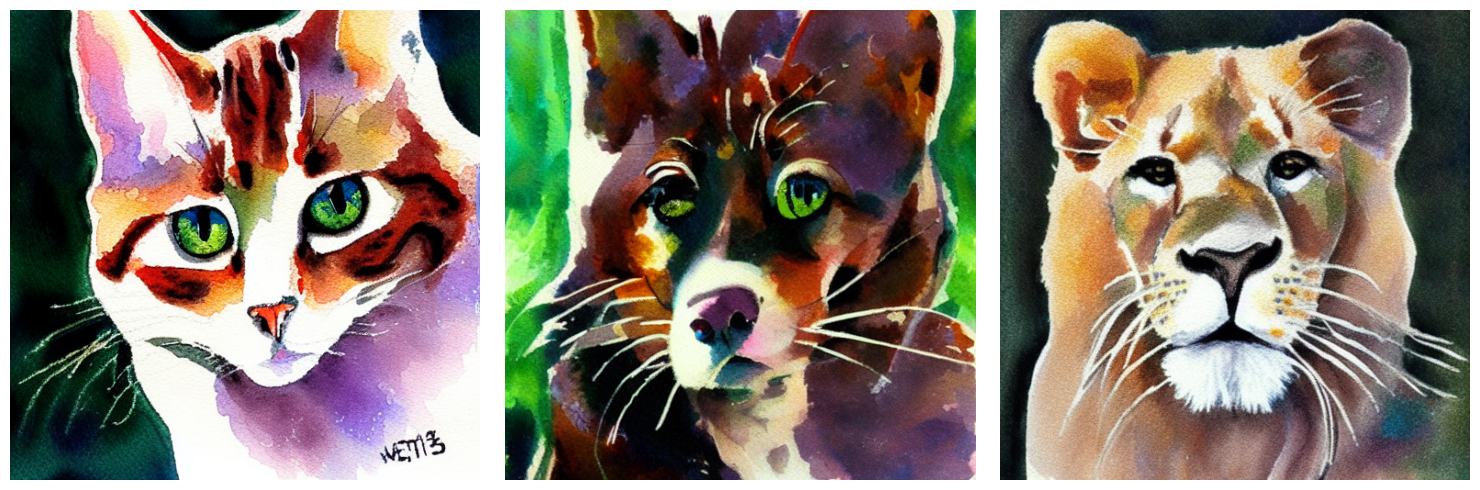

In [110]:
from text3d2video.pipelines.style_aligned_pipeline import StyleAlignedSaveDataConfig


prompts = ["Cat Watercolor Painting", "Dog", "Lion Drawing"]

module_paths = [
    # "down_blocks.0.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.0.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.1.transformer_blocks.0.attn1",
    # "mid_block.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
]

attn_processor = StyleAlignedAttentionProcessor(
    pipe.unet,
    ref_index=0,
    attend_to="both",
    adain_self_features=True,
    layers=module_paths,
)

pipe.unet.set_attn_processor(attn_processor)
pipe.attn_processor = attn_processor

gen = torch.Generator(device=device)
gen.manual_seed(0)

save_config = StyleAlignedSaveDataConfig(
    enabled=True,
    save_latents=True,
    n_noise_levels=5,
    attn_layers=module_paths,
)

ims = pipe(
    prompts,
    num_inference_steps=20,
    generator=gen,
    guidance_scale=7.5,
    save_data_config=save_config,
    save_data_file="data.h5",
)

display_ims(ims, scale=5)

In [120]:
t = 250
frame = 0
key = pipe.writer.attn_writer.read_key(t, frame, layer=module_paths[-1])
qry = pipe.writer.attn_writer.read_qry(t, frame, layer=module_paths[-1])